# Setup

In [92]:
# stop Colab backend from disconnecting
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

SyntaxError: ignored

## Install and import libraries

In [93]:
!pip3 install emnist
!pip3 install fastprogress
# !pip3 install matplotlib==3.3.2
# !pip3 install cleverhans

In [94]:
from fastprogress import master_bar, progress_bar

import emnist

import numpy as np
import pandas as pd

import tensorflow as tf
import sklearn
import sklearn.metrics
import sklearn.model_selection

import matplotlib.pyplot as plt
import seaborn as sns


# from cleverhans.attacks import FastGradientMethod, BasicIterativeMethod
# from clevehans.utils_keras import KerasModelWrapper

## GPU Warmup

In [95]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

def gpu_warmup():
  with tf.device('/device:GPU:0'):
    random_image = tf.random.normal((100,100,100,3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image)
    return tf.math.reduce_sum(net_gpu)

gpu_warmup()

Found GPU at: /device:GPU:0


<tf.Tensor: shape=(), dtype=float32, numpy=333.4361>

In [96]:
# check which GPU you are using
gpu_attributes = tf.python.client.device_lib.list_local_devices()[-1]
print(gpu_attributes.physical_device_desc)

device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


## Mount Google Drive

Google Drive is mounted to take advantage of Google's *blazing* fast upload and download speeds.

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set Constants

In [98]:
ROOT = '/content/drive/My Drive/Colab Notebooks'
STD_VALS = np.array(range(5, 40, 5)) / 100
SEED = 30034

In [99]:
fp = ROOT + '/Data/emnist-balanced-mapping.txt'
ascii_class_mapping = pd.read_csv(fp, sep=' ', header=None,).set_index(keys=0).squeeze().apply(chr).to_dict()

# Load and Peek at data

In [100]:
emnist.list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [101]:
data_subset = 'balanced'
X_train, y_train = emnist.extract_training_samples(data_subset)
X_test, y_test = emnist.extract_test_samples(data_subset)

In [102]:
TRAIN_SIZE = X_train.shape[0]
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]

In [103]:
def show_9_samples(X):
  random_ids = np.random.randint(low=0, high=len(X), size=9)
  print('Randomly selected indices: ', random_ids)
  for placement, id in enumerate(random_ids):
    plt.subplot(330+1+placement)
    plt.imshow(X[id], cmap=plt.get_cmap('gray'))
  plt.show()

Randomly selected indices:  [105484 103070  55365  38038  57434 103901  81363  31957 107692]


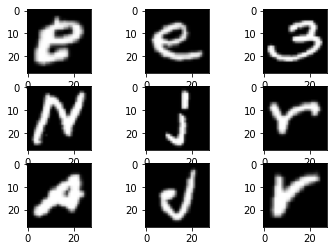

In [104]:
show_9_samples(X_train)

In [181]:
X_train_origin = X_train.reshape((X_train.shape[0], WIDTH, HEIGHT, 1)).astype('float32') / 255.0
X_test_origin = X_test.reshape((X_test.shape[0], WIDTH, HEIGHT, 1)).astype('float32') / 255.0
y_train_origin = tf.keras.utils.to_categorical(y_train)
y_test_origin = tf.keras.utils.to_categorical(y_test)

In [124]:
INPUT_SHAPE = X_train_origin.shape[1:]
N_CLASSES = y_test_origin.shape[1]

# Setup augmented data generator

In [138]:
augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    fill_mode='constant',
    cval=0,
    # height_shift_range=0.1,
    # width_shift_range=0.1,
    shear_range=20,
    rotation_range=20,
    # zoom_range=0.2,
    data_format='channels_last',
    # rescale=1.0/255,
)

## Visualise the data augmentations

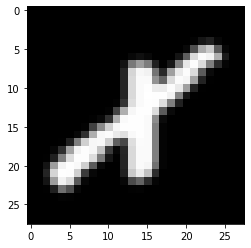

In [139]:
img = X_train_origin[100]
plt.imshow(img.reshape((28, 28)), cmap=plt.get_cmap('gray'))


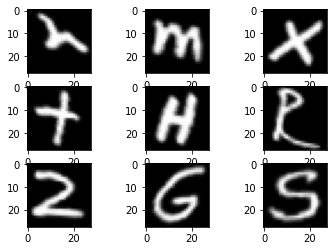

In [144]:
samples = np.expand_dims(img, 0)

iter = augmentation_generator.flow(X_train_origin, batch_size=2)

for i in range(9):
  plt.subplot(330 + 1 + i)
  batch = iter.next()
  image = batch[0]
  plt.imshow(
      image.reshape((28,28)), 
      cmap=plt.get_cmap('gray'),
  )
plt.show()

# Create Noisy Datasets

## Noise-addition function def'ns

In [ ]:
def show_img_before_after(before, after, kind=''):
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(before, cmap=plt.get_cmap('gray'))
    ax[0].set_title('Original')
    ax[1].imshow(after, cmap=plt.get_cmap('gray'))
    noisy_title = f'With {kind} Noise'
    ax[1].set_title(noisy_title)


In [ ]:
def add_gaussian_noise(original_img, sd=0.1):
  # add noise
  img_shape = original_img.shape
  original_img = original_img.copy()
  gauss = np.random.normal(0, sd, img_shape)
  new_img = original_img + gauss
  # rescale between 0-1
  img_min = new_img.min()
  img_max = new_img.max()
  new_img = (new_img - img_min) / (img_max - img_min)
  return new_img

In [ ]:
def add_speckle_noise(original_img):
  img_shape = original_img.shape
  original_img = original_img.copy()
  if img_shape.count == 3:
    row, col, ch = img_shape
    guass = np.random.randn(row, col, ch)
    guass = guass.reshape(row, col, ch)
    noisy_img = original_img + original_img*guass
  else:
    guass = np.random.normal(0, 1, img_shape)
    noisy_img = original_img + original_img*guass
  # rescale between 0-1
  img_min = noisy_img.min()
  img_max = noisy_img.max()
  noisy_img = (noisy_img - img_min) / (img_max - img_min)
  return noisy_img

In [ ]:
def add_impulse_noise(img, signal_noise, salt_pepper_ratio=0.5):
  shape = img.shape
  img = img.copy()
  unif = np.random.uniform(low=0, high=1, size=shape)
  total_noise = 1-signal_noise

  salt_amount = total_noise * salt_pepper_ratio
  salted = np.where(unif<salt_amount, 1, img)

  pepper_amount = total_noise * (1-salt_pepper_ratio)
  peppered = np.where(unif>1-pepper_amount, 0, salted)
  
  return peppered

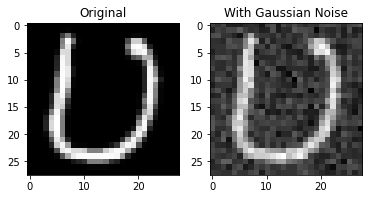

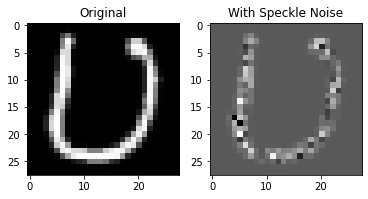

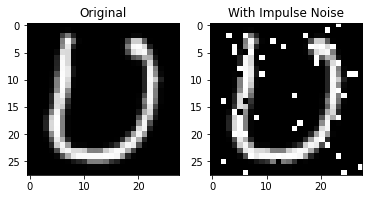

In [ ]:
# demo
img = X_train_origin[103728]
show_img_before_after(img.reshape((28, 28)), add_gaussian_noise(img, 0.10).reshape((28, 28)), kind='Gaussian')
show_img_before_after(img.reshape((28, 28)), add_speckle_noise(img).reshape((28, 28)), kind='Speckle')
show_img_before_after(img.reshape((28, 28)), add_impulse_noise(img, 0.9).reshape((28, 28)), kind='Impulse')

## Create and save the noisy examples

### Create examples with Gaussian noise

In [ ]:
def add_gauss_to_data(std_range, X_original, name):
  std_range = np.array(std_range)
  sd_names =  [f'{int(val*100):02}' for val in std_range]

  for i, sd in enumerate(std_range): 
    X_gauss = np.zeros(shape=X_original.shape)
    
    for j, img in enumerate(X_original):
      X_gauss[j] = add_gaussian_noise(img, sd=sd)

    fname = f'X_{name}_gauss_{sd_names[i]}'
    print(fname)
    np.save(ROOT + f'/Adversarial_Data/{fname}', X_gauss)

In [ ]:
%%time
add_gauss_to_data(np.array([0.3]), X_test_origin, 'test')

X_test_gauss_30
CPU times: user 1.11 s, sys: 73.5 ms, total: 1.19 s
Wall time: 1.51 s


In [ ]:
%%time
add_gauss_to_data(STD_VALS, X_train_origin, 'train')

X_train_gauss_05
X_train_gauss_10
X_train_gauss_15
X_train_gauss_20
X_train_gauss_25
X_train_gauss_30
X_train_gauss_35
CPU times: user 51.5 s, sys: 4.34 s, total: 55.8 s
Wall time: 1min 41s


## Load the noisy examples

In [ ]:
def load_gaussian(std_vals, name, X_dict={}):
  
  stds = [f'{int(val*100):02}' for val in std_vals]
  
  for std_val, std in zip(std_vals, stds):
    print(std_val, std)
    X_dict[std_val] = np.load(ROOT + f'/Adversarial_Data/X_{name}_gauss_{std}.npy') 
  
  return X_dict

In [ ]:
X_test_gauss_d = load_gaussian(std_vals=STD_VALS, name='test')
X_test_gauss_d[0.00] = X_test_origin

In [ ]:
X_train_gauss_d = load_gaussian(std_vals=np.array([0.3]), name='train')
X_train_gauss_d[0.00] = X_train_origin

0.3 30


In [ ]:
X_test_gauss_d = load_gaussian(std_vals=np.array([0.3]), name='test', X_dict=X_test_gauss_d)

0.3 30


## Peek at loaded examples

In [ ]:
def show_noise_levels(X_dict, nth_img):
  fig, axes = plt.subplots(ncols=len(X_dict))
  for i, (std, X) in enumerate(sorted(X_dict.items())):
    axes[i].imshow(X[nth_img].reshape((28,28)), cmap=plt.get_cmap('gray'))
    axes[i].set_title(f'noise: {std}')
    axes[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
  fig.set_size_inches(w=10, h=2)
  sns.despine(fig)
  return fig

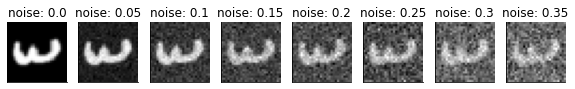

In [ ]:
fig = show_noise_levels(X_test_gauss_d, np.random.randint(low=0, high=(len(X_test_gauss_d[0]))))

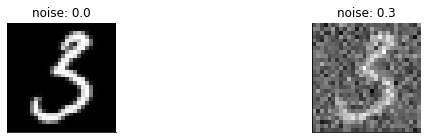

In [ ]:
fig = show_noise_levels(X_train_gauss_d, np.random.randint(low=0, high=(len(X_train_gauss_d[0]))))

# CNN Models

## Basic CNN

In [ ]:
MODEL_NAME = 'cnn_2conv_2dense'

cnn_model_base = tf.keras.Sequential(
    [
      tf.keras.layers.Conv2D(
          32, (3,3), activation='relu', kernel_initializer='he_uniform', 
          input_shape=INPUT_SHAPE
      ),
      tf.keras.layers.Conv2D(
          32, (3,3), activation='relu', kernel_initializer='he_uniform', 
      ),
      tf.keras.layers.MaxPooling2D((2,2)),     
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(4608, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dense(N_CLASSES, activation='softmax')
    ],
    name=MODEL_NAME
)
cnn_model_base.summary()

Model: "cnn_2conv_2dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 4608)              21238272  
_________________________________________________________________
dense_1 (Dense)              (None, 47)                216623    
Total params: 21,464,463
Trainable params: 21,464,463
Non-trainable params: 0
______________________________________

In [ ]:
opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
cnn_model_base.compile(
    optimizer=opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'],
    
)

In [ ]:
%%time 
base_history = cnn_model_base.fit(
    X_train_origin, y_train_origin, 
    epochs=20, batch_size=32, 
    validation_split=0.2,
    verbose=1
)
name = cnn_model_base.name
cnn_model_base.save(ROOT + '/' + name)
_, acc = cnn_model_base.evaluate(X_test_origin, y_test_origin)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Uni/3 Sem 2/MAST30034 Applied Data Science/Project/cnn_2conv_2dense/assets


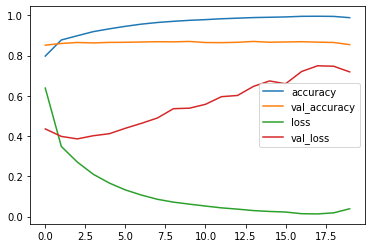

In [ ]:
sns.lineplot(
    data=base_history.history,
    dashes=False,
    hue_order = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
)

In [ ]:
pd.DataFrame(base_history.history).to_csv(ROOT + f'/{name}_history.csv')


## 3conv_3dense

In [ ]:
MODEL_NAME = 'cnn_3conv_3dense'

cnn_model_1 = tf.keras.Sequential(
    [
      tf.keras.layers.Conv2D(
          32, (3,3), activation='relu', kernel_initializer='he_uniform', 
          input_shape=INPUT_SHAPE
      ),
      tf.keras.layers.Conv2D(
          64, (3,3), activation='relu', kernel_initializer='he_uniform', 
      ),
      tf.keras.layers.Dropout(0.1),
      # tf.keras.layers.MaxPooling2D((2,2)),      
      tf.keras.layers.Conv2D(
          64, (5,5), activation='relu', kernel_initializer='he_uniform', 
      ),
      tf.keras.layers.Conv2D(
          32, (3,3), activation='relu', kernel_initializer='he_uniform', 
      ),
      tf.keras.layers.MaxPooling2D((2,2)),     
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dense(N_CLASSES, activation='softmax')
    ],
    name=MODEL_NAME
)
cnn_model_1.summary()

Model: "cnn_3conv_3dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 20, 20, 64)        102464    
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 18, 18, 32)        18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2592)         

In [ ]:
# opt = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
cnn_model_1.compile(
    optimizer='rmsprop', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'],   
)

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    ROOT + MODEL_NAME + '{epoch:02d}-{val_loss:.2f}',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True,
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
)


In [ ]:
%%time 
cnn_1_history = cnn_model_1.fit(
    X_train_origin, y_train_origin, 
    epochs=20, batch_size=32, 
    validation_split=0.2,
    callbacks=[checkpointer, stopper, lr_reducer],
    verbose=1
)
name = cnn_model_1.name
cnn_model_1.save(ROOT + '/' + name)
_, acc = cnn_model_1.evaluate(X_test_origin, y_test_origin)

Epoch 1/20
2812/2820 [============================>.] - ETA: 0s - loss: 0.6281 - accuracy: 0.7986
Epoch 00001: val_accuracy improved from -inf to 0.86130, saving model to /content/drive/My Drive/Uni/3 Sem 2/MAST30034 Applied Data Science/Projectcnn_3conv_3dense01-0.40
INFO:tensorflow:Assets written to: /content/drive/My Drive/Uni/3 Sem 2/MAST30034 Applied Data Science/Projectcnn_3conv_3dense01-0.40/assets
2820/2820 [==============================] - 19s 7ms/step - loss: 0.6273 - accuracy: 0.7988 - val_loss: 0.3976 - val_accuracy: 0.8613
Epoch 2/20
2812/2820 [============================>.] - ETA: 0s - loss: 0.4118 - accuracy: 0.8613
Epoch 00002: val_accuracy improved from 0.86130 to 0.86348, saving model to /content/drive/My Drive/Uni/3 Sem 2/MAST30034 Applied Data Science/Projectcnn_3conv_3dense02-0.38
INFO:tensorflow:Assets written to: /content/drive/My Drive/Uni/3 Sem 2/MAST30034 Applied Data Science/Projectcnn_3conv_3dense02-0.38/assets
2820/2820 [==============================] - 

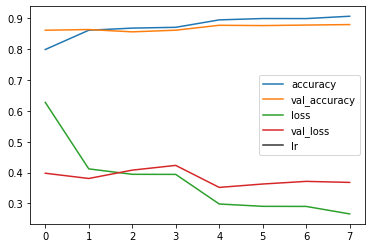

In [ ]:
sns.lineplot(
    data=cnn_1_history.history,
    dashes=False,
    hue_order = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
)

In [ ]:
cnn_model_1.predict_classes(X_test_origin)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([41, 39,  9, ..., 21, 26, 33])

## 4conv 3 dense


In [ ]:
MODEL_NAME = 'cnn_4conv_3dense_maxpool_dropout_batchnorm'

cnn_model = tf.keras.Sequential(
    [
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(WIDTH, HEIGHT, 1)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      # tf.keras.layers.MaxPooling2D((2,2)),
     
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      # tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
     
      tf.keras.layers.Conv2D(64, (2,2), activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Dropout(0.2),
      
      tf.keras.layers.Flatten(),
     
      tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_uniform'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(47, activation='softmax')
    ],
    name=MODEL_NAME
)
cnn_model.summary()

In [ ]:
opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    ROOT + MODEL_NAME + '{epoch:02d}-{val_loss:.2f}',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True,
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
)


In [ ]:
%%time 
base_history = cnn_model.fit(
    X_train, y_train, 
    epochs=20, batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[checkpointer, stopper, lr_reducer],
    verbose=1
)
_, acc = cnn_model.evaluate(X_test, y_test)
cnn_model.save(ROOT + MODEL_NAME)

Epoch 1/20
3525/3525 [==============================] - 76s 21ms/step - loss: 0.8389 - accuracy: 0.7602 - val_loss: 0.5792 - val_accuracy: 0.8342
Epoch 2/20
3525/3525 [==============================] - 75s 21ms/step - loss: 0.5978 - accuracy: 0.8145 - val_loss: 0.5024 - val_accuracy: 0.8456
Epoch 3/20
3525/3525 [==============================] - 75s 21ms/step - loss: 0.5319 - accuracy: 0.8333 - val_loss: 0.4469 - val_accuracy: 0.8523
Epoch 4/20
3525/3525 [==============================] - 75s 21ms/step - loss: 0.5269 - accuracy: 0.8378 - val_loss: 0.5103 - val_accuracy: 0.8576
Epoch 5/20
3525/3525 [==============================] - 75s 21ms/step - loss: 0.5339 - accuracy: 0.8382 - val_loss: 0.4528 - val_accuracy: 0.8495
Epoch 6/20
3525/3525 [==============================] - ETA: 0s - loss: 0.5354 - accuracy: 0.8409WARNING:tensorflow:Can save best model only with val_acc available, skipping.

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3525/3525 [==

## 7conv 1dense

### Define the model

In [ ]:
assert False

def recall(y_true, y_pred):
    y_true = tf.keras.backend.ones_like(y_true) 
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    all_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    
    recall_ = true_positives / (all_positives + tf.keras.backend.epsilon())
    return recall_

def precision(y_true, y_pred):
    y_true = tf.keras.backend.ones_like(y_true) 
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision_ = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_

def f1_score(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+tf.keras.backend.epsilon()))

In [ ]:
def cnn_7conv_1dense(name):
    
    model = tf.keras.models.Sequential(name=name)

    model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = INPUT_SHAPE))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
               
    model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))
    
    adam = tf.keras.optimizers.Adam(lr = 0.001)
    model.compile(
        optimizer = adam, 
        loss = 'categorical_crossentropy', 
        metrics = [
          'accuracy',
          'Precision',
          'Recall',
          # recall, self-calculated (probs wrong)
          # precision,
          # f1_score 
        ]
    )
    
    return model

### Regular Model

#### Fit the model

In [ ]:
MODEL_NAME = 'cnn_7conv_1dense'
cnn_7conv_1dense = cnn_7conv_1dense(MODEL_NAME)
cnn_7conv_1dense.summary()

Model: "cnn_7conv_1dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)   

In [126]:
X_train_origin_train, X_train_origin_validation, \
y_train_origin_train, y_train_origin_validation =\
sklearn.model_selection.train_test_split(
    X_train_origin,
    y_train_origin,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train,
)

In [128]:
%%time
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    ROOT + '/Models/' + MODEL_NAME + '-{epoch:02d}-{val_loss:.2f}',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
)

BATCH_SIZE = 1024,
history_cnn_7conv_1dense = cnn_7conv_1dense.fit(
    augmentation_generator.flow(
        X_train_origin_train, y_train_origin_train, 
        # batch_size=BATCH_SIZE
    ),
    validation_data=(X_train_origin_validation, y_train_origin_validation),
    epochs=50,
    batch_size=BATCH_SIZE,
    # steps_per_epoch=len(X_train_origin) / BATCH_SIZE,
    callbacks = [checkpointer, stopper, lr_reducer],
    verbose=1
)

# history_cnn_7conv_1dense = cnn_7conv_1dense.fit(
#     X_train_origin, y_train_origin, 
#     validation_split=0.2,
#     epochs=50, batch_size=32, 
#     callbacks = [checkpointer, stopper, lr_reducer],
#     verbose=2
# )

model_name = cnn_7conv_1dense.name
cnn_7conv_1dense.save(ROOT+'/Models/'+ model_name + '_aug')
pd.DataFrame(history_cnn_7conv_1dense.history).to_csv(ROOT+'/model_histories/'+ MODEL_NAME + '_aug_history.csv')

cnn_7conv_1dense_history = cnn_7conv_1dense.evaluate(X_test_origin, y_test_origin, verbose=0)

print("Baseline Error: %.2f%%" % (100-cnn_7conv_1dense_history[1]*100))
print(f'Test loss for base CNN: {cnn_7conv_1dense_history[0]} / Test accuracy: {cnn_7conv_1dense_history[1]}')

Epoch 1/50
2818/2820 [============================>.] - ETA: 0s - loss: 0.5988 - accuracy: 0.8003 - precision: 0.8607 - recall: 0.7454
Epoch 00001: val_accuracy improved from -inf to 0.88236, saving model to /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense-01-0.31
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense-01-0.31/assets
2820/2820 [==============================] - 44s 16ms/step - loss: 0.5987 - accuracy: 0.8004 - precision: 0.8607 - recall: 0.7454 - val_loss: 0.3081 - val_accuracy: 0.8824 - val_precision: 0.9077 - val_recall: 0.8602
Epoch 2/50
2817/2820 [============================>.] - ETA: 0s - loss: 0.5793 - accuracy: 0.8071 - precision: 0.8653 - recall: 0.7540
Epoch 00002: val_accuracy did not improve from 0.88236
2820/2820 [==============================] - 41s 15ms/step - loss: 0.5792 - accuracy: 0.8071 - precision: 0.8653 - recall: 0.7540 - val_loss: 0.3066 - val_accuracy: 0.8823 - val_precision: 0.9055 - v

#### Load model

In [145]:
non_augmented_model = '/Models/cnn_6conv_1dense-01-0.43'
augmented_model = '/Models/cnn_7conv_1dense_aug'

cnn_7conv_1dense = tf.keras.models.load_model(
    ROOT + '/Models/cnn_6conv_1dense-01-0.43',
    # custom_objects={
    #     'recall': recall,
    #     'precision': precision,
    #     'f1_score': f1_score,
    # }
)

#### Learning Curve

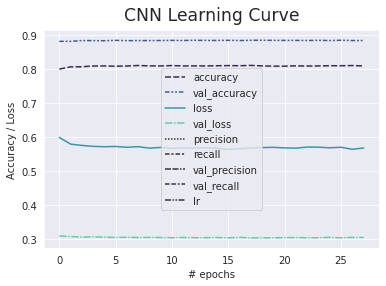

In [131]:
with sns.axes_style('darkgrid'):

  fig, ax = plt.subplots()
  sns.lineplot(
    data=history_cnn_7conv_1dense.history,
    ax=ax,
    dashes=True,
    # dashes=[False, True, False, True,False, True],
    hue_order=[
      'accuracy',
      'val_accuracy',
      'loss',
      'val_loss',
      # 'lr',
    ],

    palette='mako',
  )

  ax.set_title('CNN Learning Curve', size='xx-large', pad=10,)
  ax.set_xlabel('# epochs')
  ax.set_ylabel('Accuracy / Loss')

#### Confusion Matrix

In [ ]:
def show_confusion(model, epsilon=0.0):
  with sns.axes_style('white'):

    # calculations
    y_pred = model.predict_classes(X_test_gauss_d[epsilon])

    confusion_matrix = sklearn.metrics.confusion_matrix(
        y_true=y_test,
        y_pred = y_pred,
        normalize='true',
    )

    precision = sklearn.metrics.precision_score(
        y_true=y_test,
        y_pred=y_pred,
        average=None,
    )

    recall = sklearn.metrics.recall_score(
        y_true=y_test,
        y_pred=y_pred,
        average=None,
    )

    marginals_df = pd.DataFrame({
      'class': ascii_class_mapping.values(),
      'precision': precision,
      'recall': recall,
    })

    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(h=11, w=10)
    gs = fig.add_gridspec(
      nrows=3, ncols=2, width_ratios=[16,1], height_ratios=[1,16, 0.3],
      wspace=0.01, hspace=0.01
    )
    marg_x_ax = fig.add_subplot(gs[0, :-1])
    marg_y_ax = fig.add_subplot(gs[1:-1, -1])
    joint_ax = fig.add_subplot(gs[1:-1, 0:-1])
    cbar_ax = fig.add_subplot(gs[-1,:-1])

    default_color = sns.color_palette('mako', 50)[-1]
    accent_color = sns.color_palette('mako', 30)[-5]

    sns.barplot(
        data=marginals_df,
        y='precision',
        x='class',
        ax=marg_x_ax,
        color=default_color,
    )
    marg_x_ax.set_title('Precision', size='small')
    marg_x_ax.get_xaxis().set_visible(False)
    marg_x_ax.get_yaxis().set_visible(False)
    marg_x_ax.axhline(y=1, color=accent_color, dashes=(5,3), label='100%')
    sns.despine(ax=marg_x_ax, left=True, bottom=True)

    sns.barplot(
        data=marginals_df,
        x='recall',
        y='class',
        ax=marg_y_ax,
        color=default_color,
    )
    marg_y_ax.set_title('Recall', size='small')
    marg_y_ax.get_xaxis().set_visible(False)
    marg_y_ax.get_yaxis().set_visible(False)
    marg_y_ax.axvline(x=1, color=accent_color, dashes=(5,3), label='100%')
    sns.despine(ax=marg_y_ax, left=True, bottom=True)

    sns.heatmap(
        confusion_matrix,
        ax=joint_ax,
        xticklabels=ascii_class_mapping.values(),
        yticklabels=ascii_class_mapping.values(),
        cmap='mako_r',
        cbar=True,
        cbar_ax=cbar_ax,
        cbar_kws={
            'orientation': 'horizontal',
            'shrink' : 0.7,
            'fraction': 0.05,
            'aspect': 40,
        },
        annot=False,
        fmt='.1f',
        annot_kws={
            'alpha': 0.8,
            'fontsize': 10,
        },
        # square=True,
        linecolor='white',
        linewidth=0.004,
    )  
    joint_ax.tick_params(bottom=False, left=False, labeltop=True, labelright=True, labelrotation=0.0)
    joint_ax.set_ylabel('True class label', size='medium', labelpad=10)
    joint_ax.set_xlabel('Predicted class label', size='medium', labelpad=10)

    cbar_ax.set_xlabel('True proportion identified', size='small')
    fig.suptitle('CNN Classifier Confusion Matrix', size='xx-large', va='top', )

  return fig

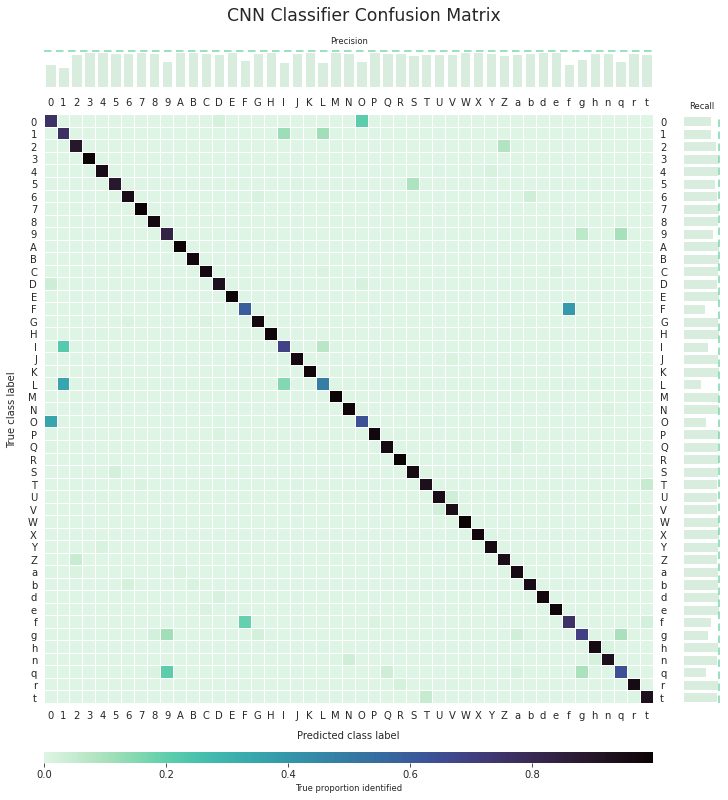

In [ ]:
fig = show_confusion(0.00)

In [ ]:
show_confusion(0.1)

NameError: ignored

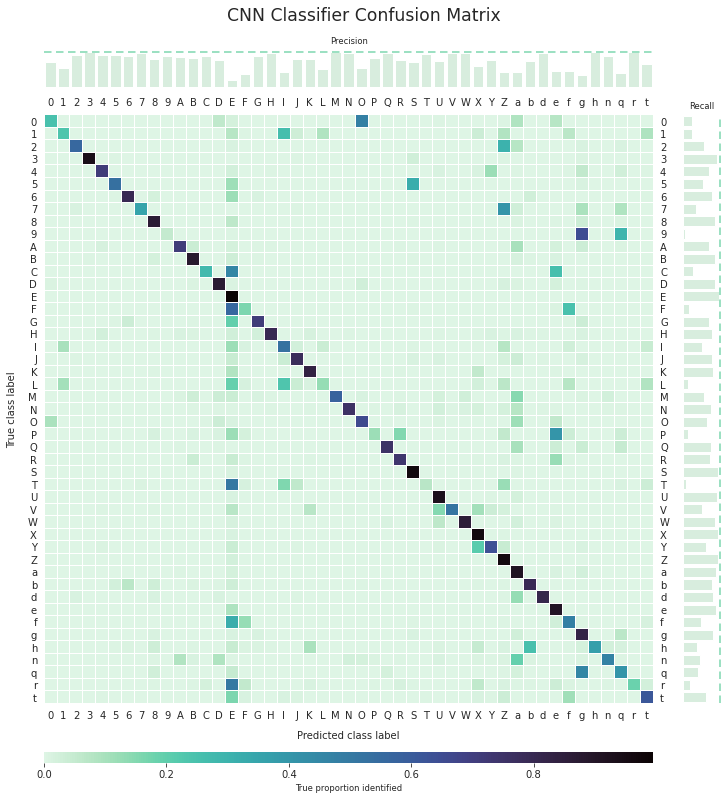

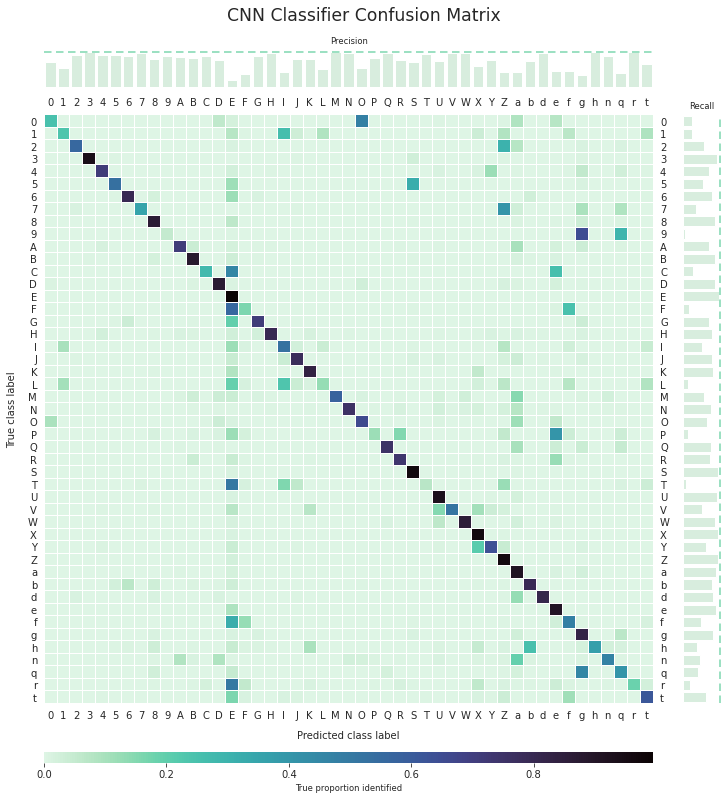

In [ ]:
show_confusion(0.2)

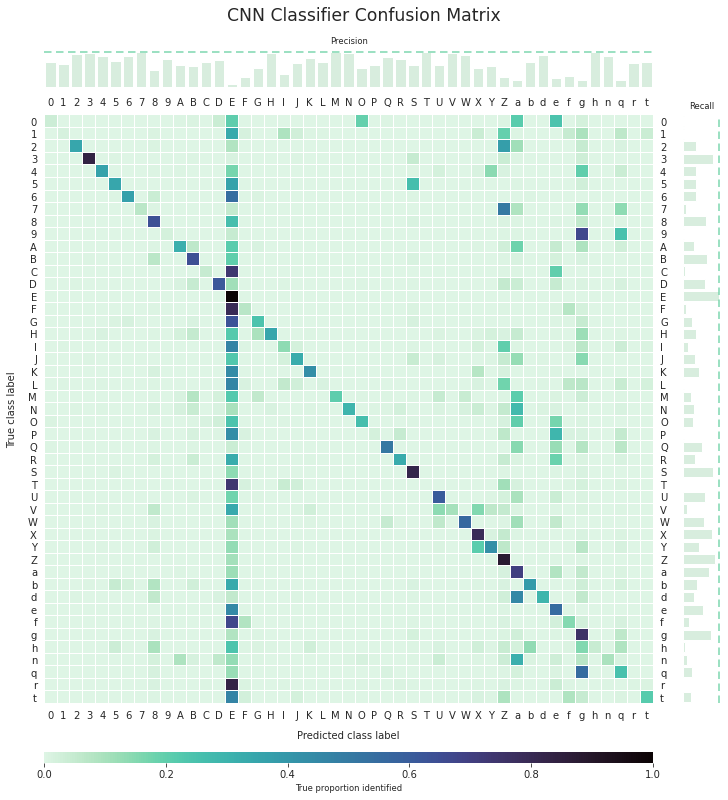

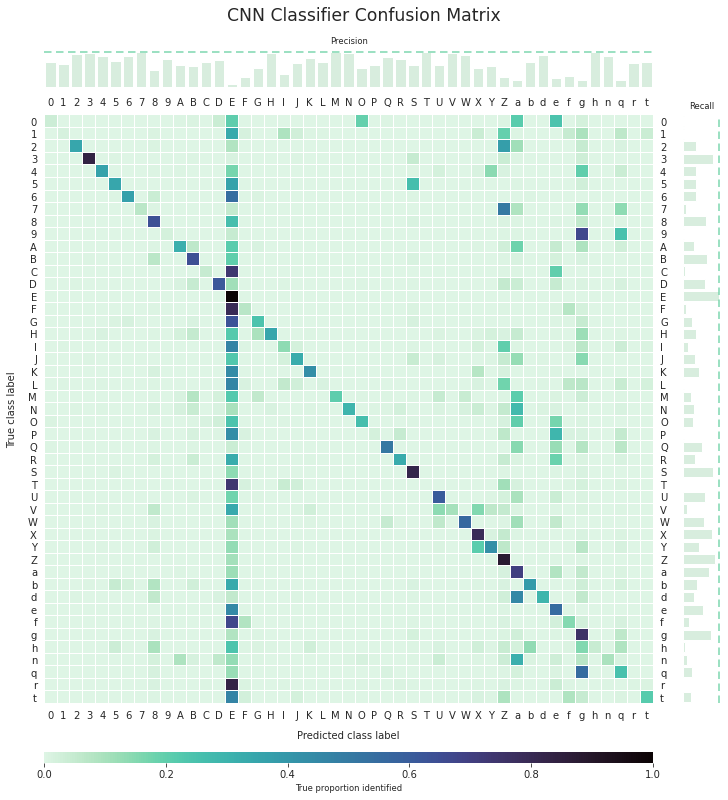

In [ ]:
show_confusion(0.3)

#### Performance on noisy data

In [ ]:
noise_degradation = dict()
for std_val, noisy_test_set in X_test_gauss_d.items():

  results = cnn_7conv_1dense.evaluate(
      x=noisy_test_set,
      y=y_test_origin,
      return_dict=True,
  )

  noise_degradation[std_val] = results

noise_degradation_df = pd.DataFrame(noise_degradation).transpose().reset_index().rename(columns={'index': 'epsilon'})
noise_degradation_df = pd.melt(
    noise_degradation_df, 
    id_vars=['epsilon'],
    value_vars=['loss', 'accuracy', 'precision', 'recall']
)

588/588 [==============================] - 3s 5ms/step - loss: 0.2851 - accuracy: 0.9025 - precision: 0.9165 - recall: 0.8906


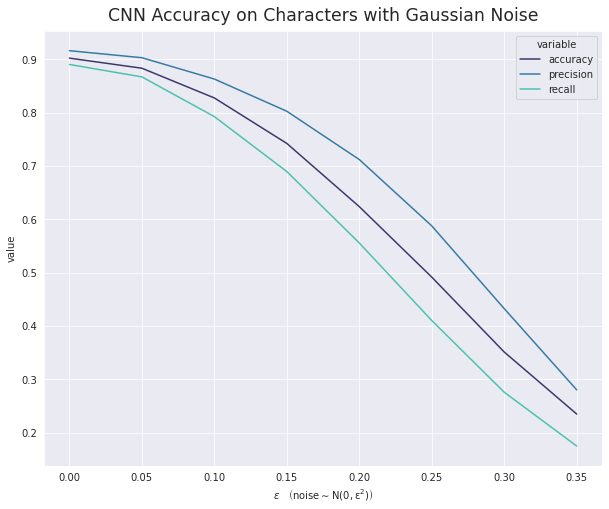

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(
    data=noise_degradation_df,
    x='epsilon',
    y='value',
    hue='variable',
    hue_order = ['accuracy', 'precision', 'recall'],
    ax=ax,
    palette='mako'
)
ax.set_title('CNN Accuracy on Characters with Gaussian Noise', size='xx-large', pad=10)
ax.set_xlabel(r'$\epsilon \quad \left(\rm{noise} \sim N\left(0, \epsilon^{2}\right)\right)$')
fig.set_size_inches(h=8, w=10)

### Adversarially trained Model

In [ ]:
MODEL_NAME = 'cnn_7conv_1dense_adversarial'
cnn_7conv_1dense_adversarial = cnn_7conv_1dense(MODEL_NAME)
cnn_7conv_1dense_adversarial.summary()


Model: "cnn_7conv_1dense_adversarial"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_16 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 12

In [ ]:
%%time 
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    ROOT + '/Models/' + MODEL_NAME + '-{epoch:02d}-{val_loss:.2f}',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
)

history_cnn_7conv_1dense_adversarial = cnn_7conv_1dense_adversarial.fit(
    X_train_gauss_d[0.3], y_train_origin, 
    validation_split=0.2,
    epochs=50, batch_size=32, 
    callbacks = [checkpointer, stopper, lr_reducer],
    verbose=2
)
name = cnn_7conv_1dense_adversarial.name
cnn_7conv_1dense_adversarial.save(ROOT+'/Models/'+name)
pd.DataFrame(history_cnn_7conv_1dense_adversarial.history).to_csv(ROOT+'/model_histories/'+MODEL_NAME + '_history.csv')

scores_cnn_7conv_1dense_adversarial = cnn_7conv_1dense_adversarial.evaluate(X_test_origin, y_test_origin, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores_cnn_7conv_1dense_adversarial[1]*100))
print(f'Test loss for base CNN: {scores_cnn_7conv_1dense_adversarial[0]} / Test accuracy: {scores_cnn_7conv_1dense_adversarial[1]}')

Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.82943, saving model to /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_adversarial-01-0.49
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_adversarial-01-0.49/assets
2820/2820 - 20s - loss: 1.0266 - accuracy: 0.6926 - precision: 0.8197 - recall: 0.5928 - val_loss: 0.4917 - val_accuracy: 0.8294 - val_precision: 0.8622 - val_recall: 0.8022
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.82943 to 0.84145, saving model to /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_adversarial-02-0.44
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Models/cnn_7conv_1dense_adversarial-02-0.44/assets
2820/2820 - 20s - loss: 0.5710 - accuracy: 0.8096 - precision: 0.8596 - recall: 0.7623 - val_loss: 0.4364 - val_accuracy: 0.8414 - val_precision: 0.8726 - val_recall: 0.8158
Epoch 3/50

Epoch 00003: val_accuracy improved from 0.84145

#### Learning curves

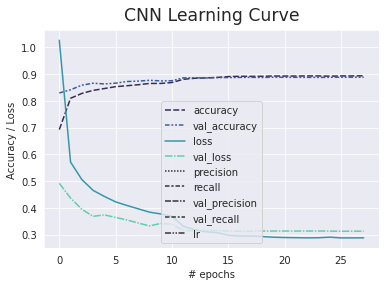

In [ ]:
with sns.axes_style('darkgrid'):

  fig, ax = plt.subplots()
  sns.lineplot(
    data=history_cnn_7conv_1dense_adversarial.history,
    ax=ax,
    dashes=True,
    # dashes=[False, True, False, True,False, True],
    hue_order=[
      'accuracy',
      'val_accuracy',
      'loss',
      'val_loss',
      # 'lr',
    ],
    palette='mako',
  )

  ax.set_title('CNN Learning Curve', size='xx-large', pad=10,)
  ax.set_xlabel('# epochs')
  ax.set_ylabel('Accuracy / Loss')

#### Confusion Matrix

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


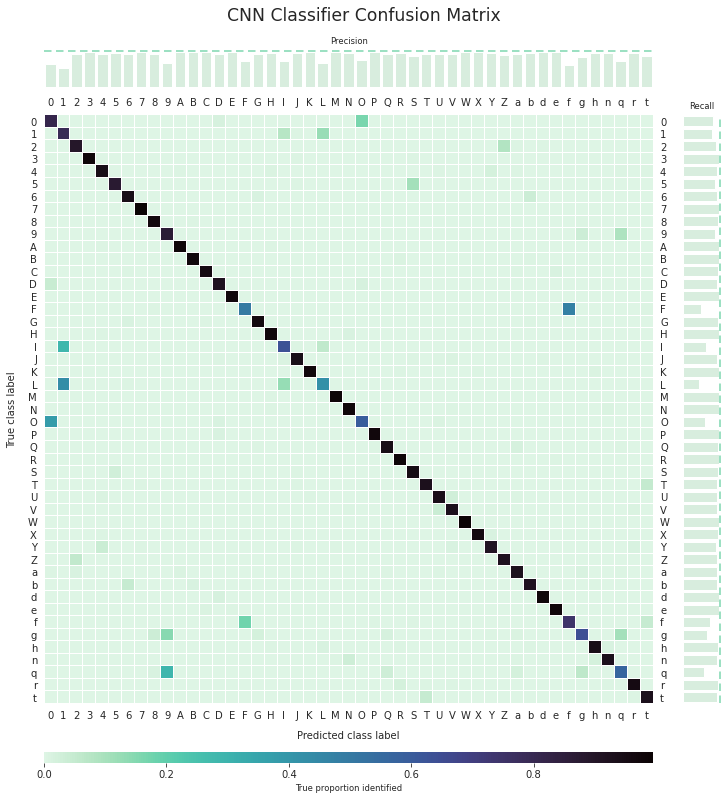

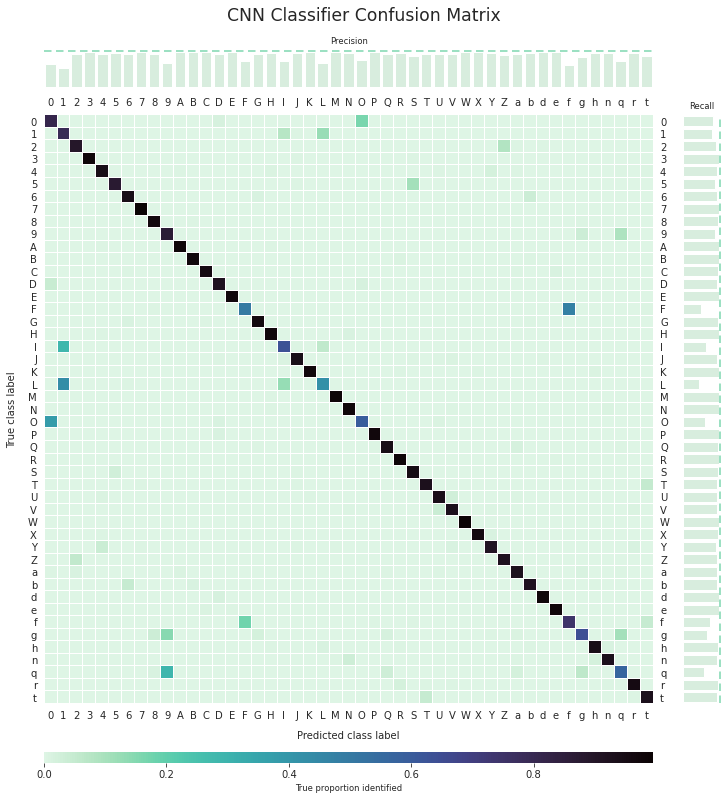

In [ ]:
fig =show_confusion(cnn_7conv_1dense_adversarial, epsilon=0.0)

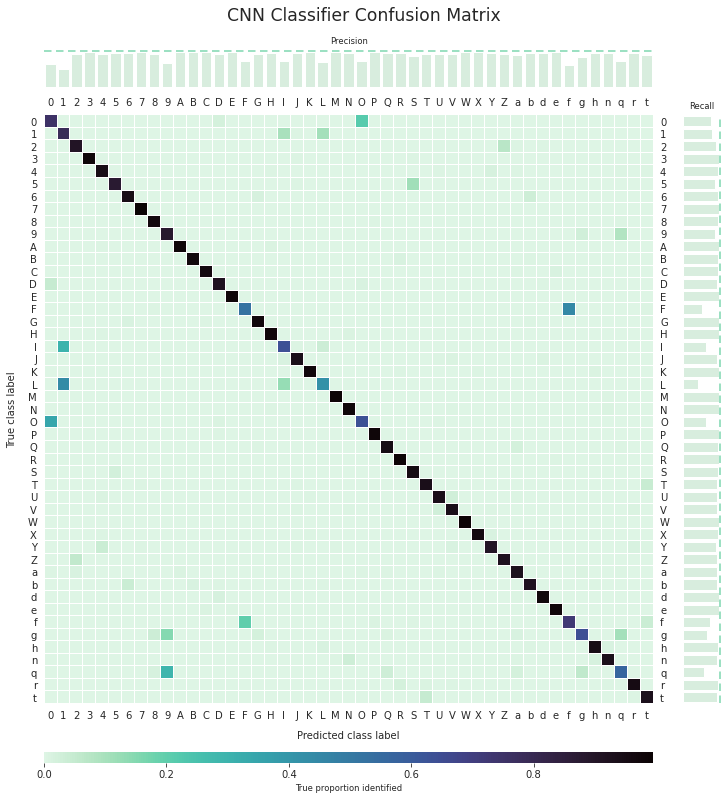

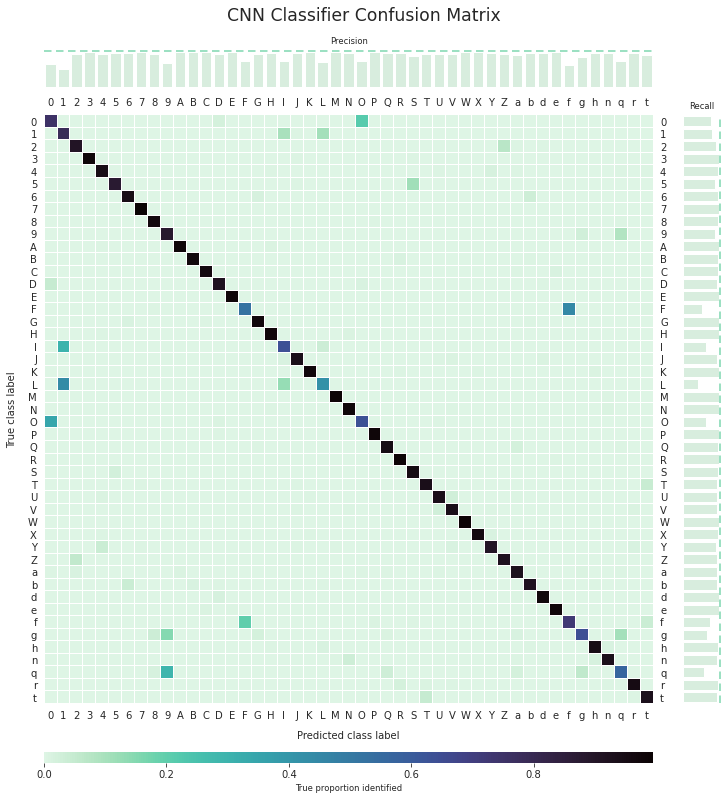

In [ ]:
show_confusion(cnn_7conv_1dense_adversarial, epsilon=0.1)

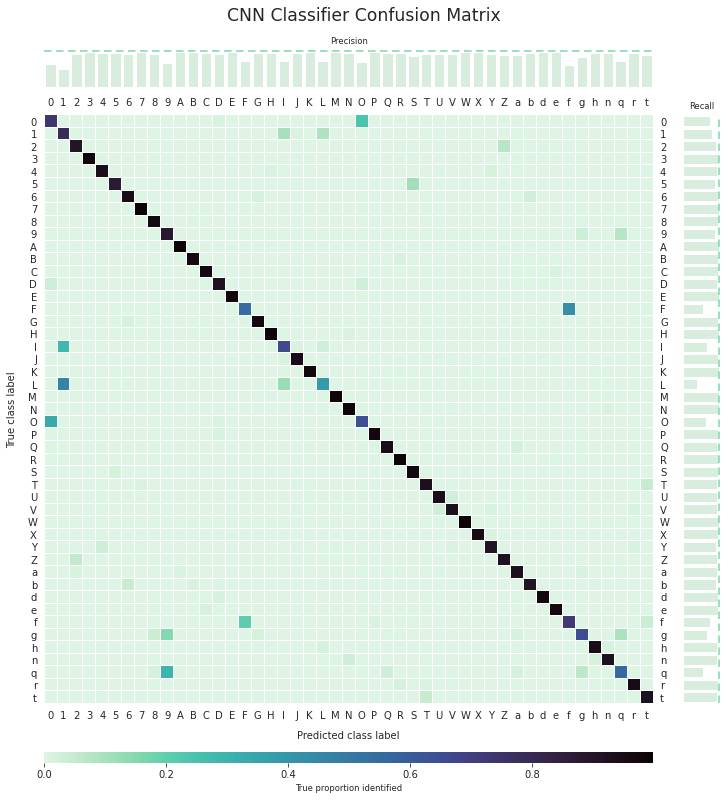

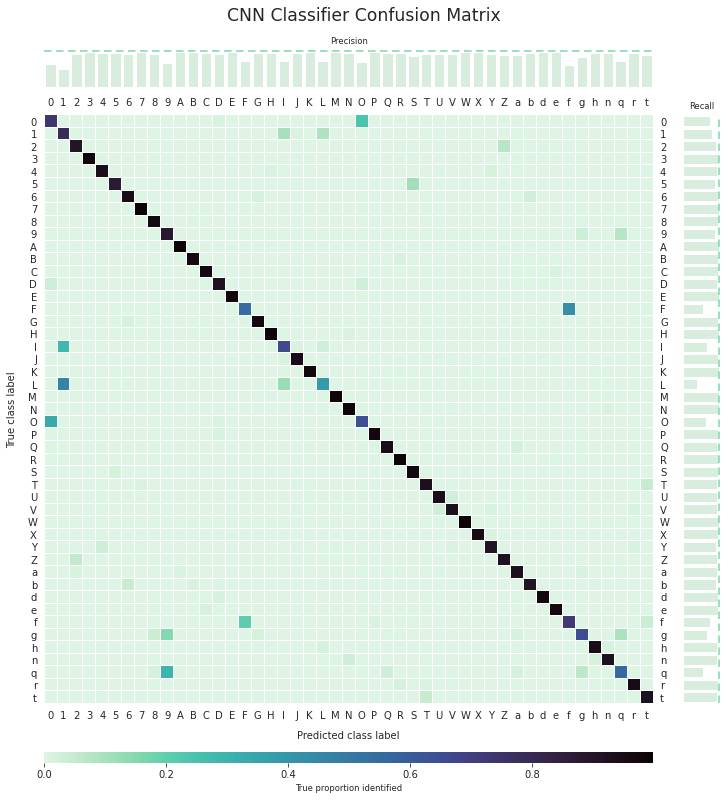

In [ ]:
show_confusion(cnn_7conv_1dense_adversarial, epsilon=0.2)

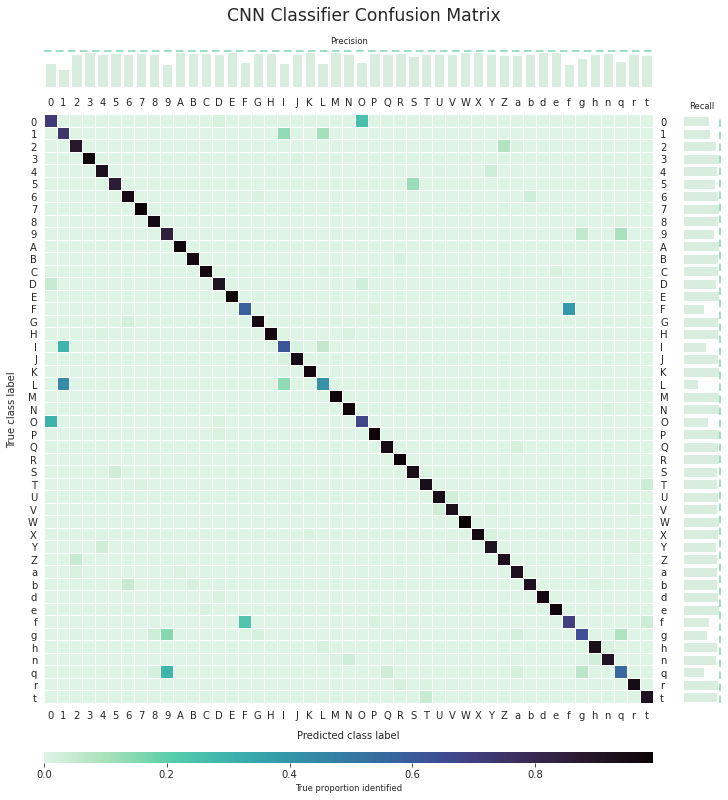

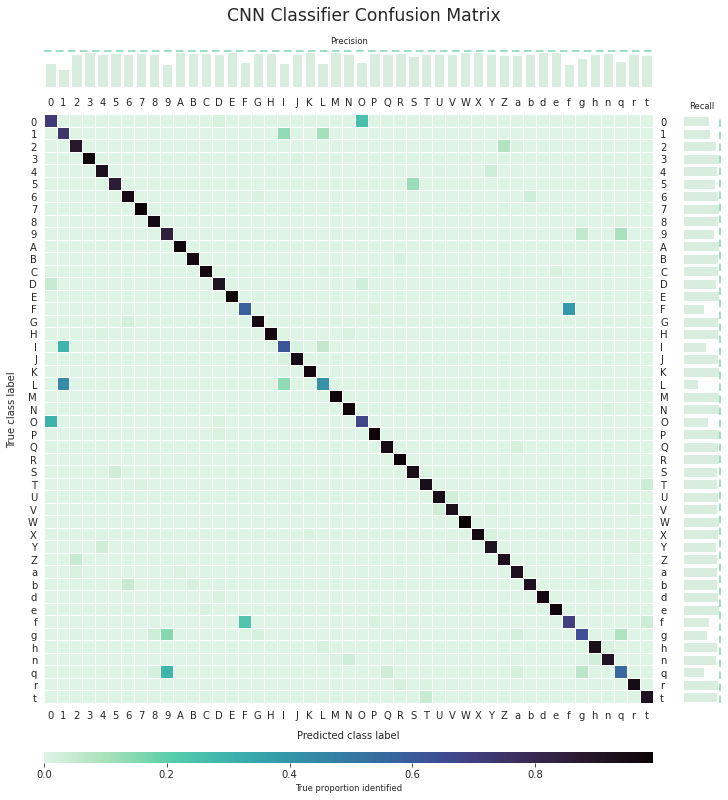

In [ ]:
show_confusion(cnn_7conv_1dense_adversarial, epsilon=0.3)

#### Performance on noisy data

In [ ]:
def show_adversary_degradation(model, adv_d, adversary_kind, model_kind):
  adv_degradation = dict()
  for adv_amount, adv_test_set in adv_d.items():

    results = model.evaluate(
        x=adv_test_set,
        y=y_test_origin,
        return_dict=True,
    )

    adv_degradation[adv_amount] = results

  adv_degradation_df = pd.DataFrame(adv_degradation).transpose().reset_index().rename(columns={'index': 'epsilon'})
  adv_degradation_df = pd.melt(
      adv_degradation_df, 
      id_vars=['epsilon'],
      value_vars=['loss', 'accuracy', 'precision', 'recall']
  )

  fig, ax = plt.subplots()
  sns.lineplot(
      data=adv_degradation_df,
      x='epsilon',
      y='value',
      hue='variable',
      hue_order = ['accuracy', 'precision', 'recall'],
      ax=ax,
      palette='mako'
  )
  ax.set_title(f'{model_kind} Accuracy on {adversary_kind} Characters', size='xx-large', pad=10)
  ax.set_xlabel(r'$\epsilon \quad \left(\rm{noise} \sim N\left(0, \epsilon^{2}\right)\right)$', size='large')
  ax.set_ylabel('value', size='large')
  fig.set_size_inches(h=8, w=10)

588/588 [==============================] - 3s 5ms/step - loss: 0.3097 - accuracy: 0.8905 - precision: 0.9071 - recall: 0.8770


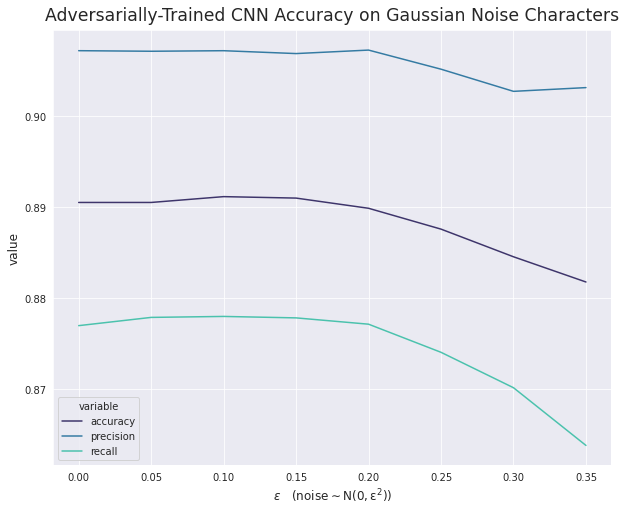

In [ ]:
with sns.axes_style('darkgrid'):
  show_adversary_degradation(
      model=cnn_7conv_1dense_adversarial, 
      adv_d=X_test_gauss_d,
      adversary_kind='Gaussian Noise',
      model_kind='Adversarially-Trained CNN'
  )

# FGSM Attack

In [182]:
cnn_7conv_1dense.trainable = False

In [183]:
image = X_train_origin[0].reshape((1,28,28,1))
image_probs = cnn_7conv_1dense.predict(image)

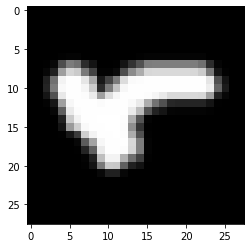

In [184]:
plt.imshow(image.reshape((28,28)), cmap=plt.get_cmap('gray'))

In [185]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, model):
  input_image = tf.convert_to_tensor(input_image)
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss= loss_object(input_label, prediction)
  
  # get gradient of loss w.r.t image
  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

In [186]:
label = y_train_origin[0].reshape((1,47))
perturbations = create_adversarial_pattern(image, label, cnn_7conv_1dense).numpy()

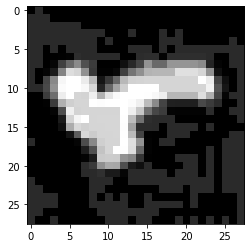

In [189]:
plt.imshow((image + 0.1 *perturbations).reshape((28,28)), cmap=plt.get_cmap('gray'))

In [ ]:
def display_images(image, description, pretrained_model):
  label = pretrained_model.predict_classes(image)[0]
  confidence = pretrained_model.predict_proba(image)[:,label]
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

TypeError: ignored

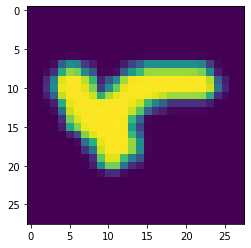

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i], cnn_7conv_1dense)

## Create adversarial examples

In [ ]:
def fgsm_from_data(epsilons, X_original, y_original, model, name):
  epsilons = np.array(epsilons)
  eps_names =  [f'{int(val*100):02}' for val in epsilons]

  for i, sd in enumerate(epsilons): 
    X_fgsm = np.zeros(shape=X_original.shape)
    
    for j, img in enumerate(X_original):
      img = img.reshape((1,28,28,1))
      lbl = y_original[j].reshape((1,N_CLASSES))
      X_fgsm[j] = create_adversarial_pattern(img, lbl, model)

    fname = f'X_{name}_fgsm_{eps_names[i]}'
    print(fname)
    np.save(ROOT + f'/Adversarial_Data/{fname}', X_fgsm)

In [ ]:
fgsm_from_data(
    epsilons=[0.01, 0.1, 0.2], 
    X_original=X_train_origin, 
    y_original=y_train_origin,
    model=cnn_7conv_1dense,
    name='train',
)

TypeError: ignored

In [ ]:
fgsm_from_data(
    epsilons=[0.01, 0.1, 0.2], 
    X_original=X_test_origin, 
    y_original=y_test_origin,
    model=cnn_7conv_1dense,
    name='test',
)

X_test_fgsm_01
X_test_fgsm_10
X_test_fgsm_20


## Load adversarial examples

In [ ]:
def load_fgsm(eps_vals, name, X_dict={}):
  
  epsilon_names = [f'{int(val*100):02}' for val in eps_vals]
  
  for esp_val, eps_name in zip(eps_vals, epsilon_names):
    print(esp_val, eps_name)
    X_dict[esp_val] = np.load(ROOT + f'/Adversarial_Data/X_{name}_fgsm_{eps_name}.npy') 
  
  return X_dict

In [ ]:
X_test_fgsm_d = load_fgsm([0.01, 0.1, 0.2], 'test')

0.01 01
0.1 10
0.2 20


[16283 12573  9858  4483 18520  5385  7370 18553 13454]


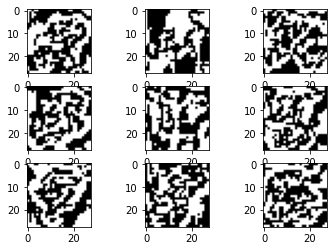

In [ ]:
show_9_samples(X_test_fgsm_d[0.01])

In [ ]:
show_adversary_degradation(
    cnn_7conv_1dense,
    X_test_fgsm_d,
    'FGSM-generated',
    model
)